In [144]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2 as cv
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)

# BBox resizing

The bbox is resized in an organized manner and can be easily deduced using the original image size.

In [99]:
resolution = 512
preprocess = Compose(
    [ # classic squared aspect-preserved centered image
        Resize(resolution, interpolation= InterpolationMode.BILINEAR),
        CenterCrop(resolution), 
    ]
)

In [255]:
# example client
client_id = 'demd6827'

# get dataframe
df = pd.read_csv('breast40k_RGB.csv')
# filter
df = df[df['client_id'] == client_id]
df = df[df['marks'] == True]

i = 0 # df iloc

Get original bounding box

In [261]:
bbox = df.iloc[i]['bbox']
side = df.iloc[i]['image_laterality']
# get x1, y1, x2, y2 coordinates form string in that order
bbox = bbox.replace('(', '').replace(')', '').split(',')
x1, y1, x2, y2 = [int(i) for i in bbox]
coord = np.asarray([x1, y1, x2, y2])
print(coord)

[2527  991 2622 1146]


Read original image and resize

In [257]:
# add png extension
file_name = df.iloc[i].image_id + '.png'
image_path = repo_path / 'data/images/breast40k' / file_name
image_path_RGB = repo_path / 'data/images/breast40k_RGB' / file_name
# read image
im = Image.open(image_path)
im_preprocessed = np.asarray(preprocess(im))
im = np.asarray(im)

# image sizes
original_size = im.shape
# reshape size
reshape_size = im_preprocessed.shape
print(f'Original size: {original_size}\nReshape size: {reshape_size}')

# if side is right, flip x coordinate
if side == 'R':
    coord[0] =  original_size[1] - coord[0] -1
    coord[2] =  original_size[1] - coord[2] -1
    
    print(f'Flipped coordinates: {coord}')

Original size: (4096, 3328)
Reshape size: (512, 512)
Flipped coordinates: [ 800  991  705 1146]


The image will be always resized with the smaller side (the width)

In [258]:
# get resized bounding box coordinates
orig_height = original_size[0]
orig_width = original_size[1]
# vector of coordinates
coord_r = (coord * (resolution / orig_width))
coord_r = np.round(coord_r).astype(int) # round to nearest int
print(coord_r)

# get the resized height and width difference beffofe cropping to remove from y coordinates (the larger, height)
resize_diff = int((orig_height * resolution)/orig_width) - resolution
resize_diff = int(resize_diff/2)
# substract from y1 and y2
coord_r[1] = coord_r[1] - resize_diff
coord_r[3] = coord_r[3] - resize_diff
print(coord_r)

[123 152 108 176]
[123  93 108 117]


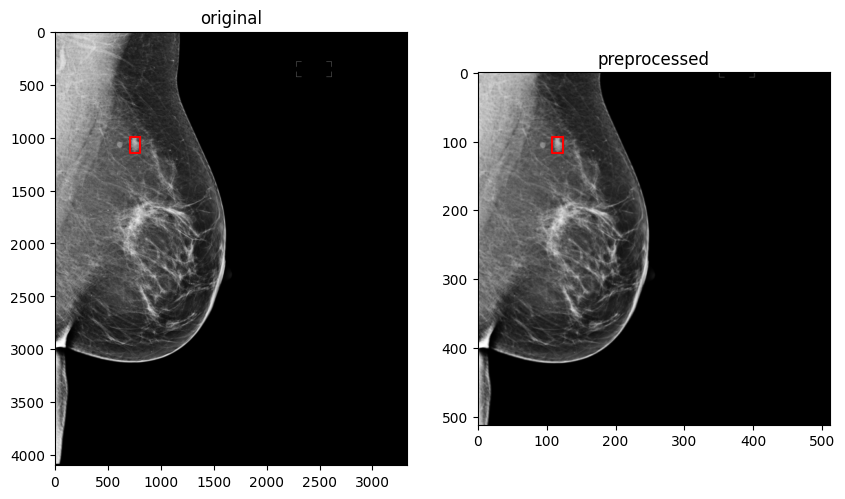

In [259]:
# plot original and preprocessed
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('original')
# plot the bbox
ax[0].plot([coord[0], coord[0], coord[2], coord[2], coord[0]], [coord[1], coord[3], coord[3], coord[1], coord[1]], color='r')
ax[1].imshow(im_preprocessed, cmap='gray')
ax[1].set_title('preprocessed')
# plot the bbox
ax[1].plot([coord_r[0], coord_r[0], coord_r[2], coord_r[2], coord_r[0]], [coord_r[1], coord_r[3], coord_r[3], coord_r[1], coord_r[1]], color='r')

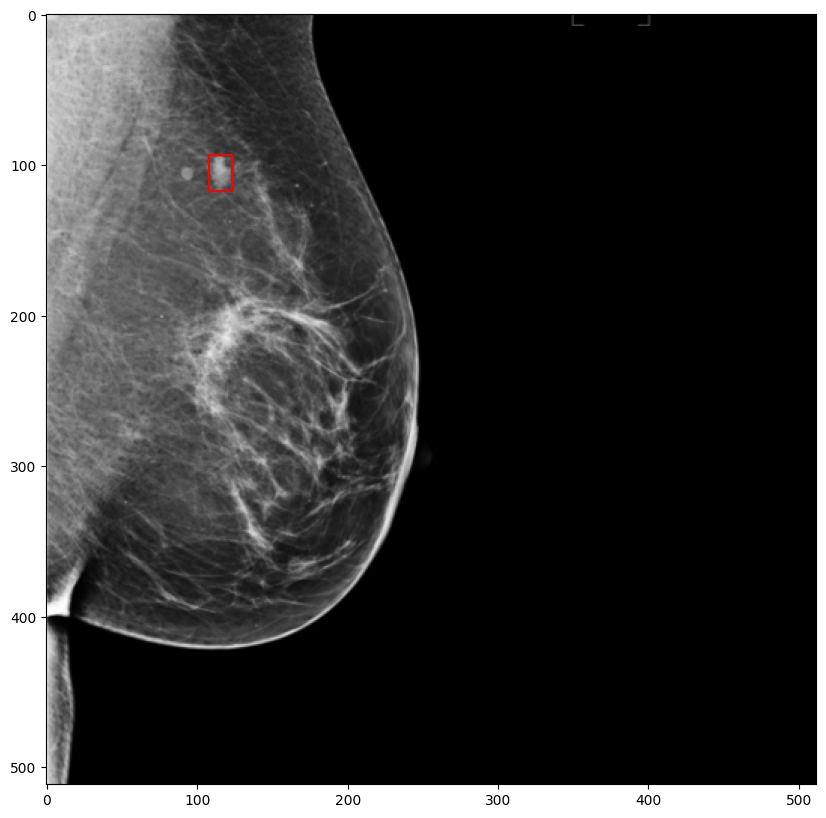

In [260]:
im_preprocessed_RGB = cv.imread(str(image_path_RGB))[:,:,0]
# get img histogram
hist = cv.calcHist([im_preprocessed_RGB],[0],None,[256],[0,256])
# get zero pixels
zero_pixels = np.where(im_preprocessed_RGB == 0)
# create binary mask of the zero pixels and invert it
mask = np.zeros(im_preprocessed_RGB.shape, dtype=np.uint8)
mask[zero_pixels] = 1
mask = 1 - mask # invert mask
# plot mask and original image in same figure
plt.figure(figsize=(10,10))
plt.imshow(im_preprocessed_RGB, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.0)
plt.plot([coord_r[0], coord_r[0], coord_r[2], coord_r[2], coord_r[0]], [coord_r[1], coord_r[3], coord_r[3], coord_r[1], coord_r[1]], color='r')

# Saving healthy

In [24]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2 as cv
import pandas as pd

# code to save only the healthy images using the metadata information


source_folder = 'breast40k_RGB'
saving_folder = 'breast40k_RGB_healthy'

# read the metadata
metadata_path = repo_path / 'data/metadata' / f'{source_folder}.csv'
metadata = pd.read_csv(metadata_path)

# filter metadata to only keep healthy images, meaning without marks
metadata = metadata[metadata['marks'] == False]
# reset index
metadata.reset_index(inplace=True, drop=True)
# go through all images in the metadata
break_i = 10
for i, row in tqdm(metadata.iterrows()):
    print(row['image_id'], i)
    if i == break_i: # early break for debugging
        break

10it [00:00, 397.05it/s]

1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.38.0 0
1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.35.0 1
1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.26.0 2
1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.30.0 3
1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.21.0 4
1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.13.0 5
1.2.826.0.1.3680043.9.3218.1.1.3923122377.1414.1545816414409.5.0 6
1.2.826.0.1.3680043.9.3218.1.1.102338111.1329.1542916673146.20.0 7
1.2.826.0.1.3680043.9.3218.1.1.102338111.1329.1542916673146.23.0 8
1.2.826.0.1.3680043.9.3218.1.1.102338111.1329.1542916673146.27.0 9
1.2.826.0.1.3680043.9.3218.1.1.102338111.1329.1542916673146.41.0 10


In [15]:
row['image_id']

'1.2.826.0.1.3680043.9.3218.1.1.392312237.1414.1545816414409.38.0'